In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('Exploration').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [2]:
spark

In [35]:
sqlContext = pyspark.SQLContext(sc)
review = sqlContext.read.json('hdfs://0.0.0.0:19000/data/review.json')
review.dtypes

[('business_id', 'string'),
 ('cool', 'bigint'),
 ('date', 'string'),
 ('funny', 'bigint'),
 ('review_id', 'string'),
 ('stars', 'double'),
 ('text', 'string'),
 ('useful', 'bigint'),
 ('user_id', 'string')]

In [37]:
business = sqlContext.read.json('hdfs://0.0.0.0:19000/data/business.json')
business.dtypes

[('address', 'string'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoking:string,WheelchairAccessible:string,WiFi:string>'),
 ('business_id', 'string'),
 ('categories', 'string'),
 ('city', 'string'),
 ('hours',
  'struct<Friday:st

In [60]:
business.createOrReplaceTempView("business")
review.createOrReplaceTempView("review")

review_subset=spark.sql("select * from review where text is not null and stars=1")
business_subset=spark.sql("select * from business where categories='Restaurants, Pizza'")

review_subset.createOrReplaceTempView("review_subset")
business_subset.createOrReplaceTempView("business_subset")

bad_reviews=spark.sql("select r.text from review_subset r \
inner join business_subset b \
on r.business_id=b.business_id")

bad_reviews_selected_columns=spark.sql("select b.business_id,r.text,r.date,r.stars,r.useful from review_subset r \
inner join business_subset b \
on r.business_id=b.business_id")

bad_reviews.head(1)

[Row(text="So....they changed their prices. One star because the girl at the counter was sweet. I used to get the grilled chicken pasta for 9.00 and now it's 15.00! I can't afford to go back. I think loyalty supercedes trying to make an extra buck. Be loyal to your customers and they will return. I would have been sympathetic to a dollar more, but that's too high a jump. The pasta is good, but not Olive Garden in California  great. I'll never understand why food tastes better in Cali.")]

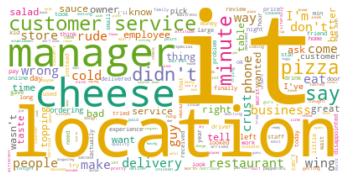

In [58]:
import pandas as pd

bad_reviews_pd=bad_reviews.toPandas()

# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(['good','went','did','didn''t','said','it','pizza','slice','told','order','ordered','food','just','I''m','going','like','really','asked','place','time','got','called','came'])

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate(' '.join(bad_reviews_pd['text']))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.show()
plt.savefig("C:\\bigdata\data\yelp_dataset\plots\mygraph.png")

In [64]:
import json
import csv
import re
import string
import pandas as pd

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

bad_reviews_selected_pd=bad_reviews_selected_columns.toPandas()

bad_reviews_selected_pd['text'] = bad_reviews_selected_pd['text'].apply(lambda x: clean_text(x))

bad_reviews_selected_pd.head(1)

,business_id,text,date,stars,useful
0,k2b3niokS_tosjah_rzCPw,sothey changed their prices one star because t...,2016-05-07 02:24:45,1.0,0


In [67]:
bad_reviews_selected_pd.to_csv('C:\\bigdata\data\yelp_dataset\output\\bad_reviews.csv')

In [68]:
spark.sql("select categories,count(*) as cnt from business group by 1 order by cnt desc").collect()

[Row(categories='Restaurants, Pizza', cnt=1042),
 Row(categories='Nail Salons, Beauty & Spas', cnt=1031),
 Row(categories='Pizza, Restaurants', cnt=993),
 Row(categories='Beauty & Spas, Nail Salons', cnt=947),
 Row(categories='Food, Coffee & Tea', cnt=888),
 Row(categories='Mexican, Restaurants', cnt=885),
 Row(categories='Coffee & Tea, Food', cnt=865),
 Row(categories='Restaurants, Mexican', cnt=853),
 Row(categories='Chinese, Restaurants', cnt=840),
 Row(categories='Hair Salons, Beauty & Spas', cnt=831),
 Row(categories='Beauty & Spas, Hair Salons', cnt=819),
 Row(categories='Restaurants, Chinese', cnt=789),
 Row(categories='Automotive, Auto Repair', cnt=585),
 Row(categories='Auto Repair, Automotive', cnt=534),
 Row(categories='Food, Grocery', cnt=492),
 Row(categories='Grocery, Food', cnt=491),
 Row(categories=None, cnt=482),
 Row(categories='Restaurants, Italian', cnt=474),
 Row(categories='Italian, Restaurants', cnt=446),
 Row(categories='Banks & Credit Unions, Financial Services

In [70]:
bad_reviews[bad_reviews_selected_pd.business_id['k2b3niokS_tosjah_rzCPw']

TypeError: unexpected item type: <class 'pandas.core.series.Series'>